In [1]:
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm as cmx
from scipy import optimize, stats
import bluepyopt as bpop
import curve_fitting as cf
import bluepyopt.deapext.algorithms as algo
import generalized_genSim_shorten_time as ggsd
import vclamp_evaluator_HMM as vcl_ev
import pickle
import time
from deap import tools
#from deap import base, creator
import multiprocessing
import eval_helper_na16 as eh16
#import eval_helper as eh
#import scoring_functions_relative as sf
#import curve_fitting as cf

In [7]:
import numpy as np
import bluepyopt as bpop
import matplotlib.pyplot as plt

class Vclamp_evaluator_HMM(bpop.evaluators.Evaluator):

    def __init__(self, scaled):
        
        self.scaled = scaled
        
        # (val, min, max)
        param_range_dict = eh16.read_params_range("param_stats_wide.csv")
        params_in_name = eh16.get_name_params_str()
        params_not_in_Range_dict = ['qq', 'tq']
        
        eh16.set_param(eh16.get_wt_params())
        
        # diff is mut - wild
        # first get baseline data points:
        gv_slope, v_half, top, bottom = cf.calc_act_obj("na16", is_HMM=False)
        self.act_v_half = v_half
        self.act_slope = gv_slope
        ssi_slope, v_half, top, bottom, tau0 = cf.calc_inact_obj("na16", is_HMM=False)
        self.inact_v_half = v_half
        self.inact_slope = ssi_slope
        self.tau0 = eh16.find_tau0()
        
        def init_params():
            param_list = []
            print("here are the name, val, min, max of each parameter")
            for param in params_in_name:
                if param not in params_not_in_Range_dict:
                    print(param)
                    val = param_range_dict[param][0]
                    min_bound = param_range_dict[param][1]
                    max_bound = param_range_dict[param][2]
                    print(val)
                    print((min_bound, max_bound))
                    print("")
                    param_list.append(bpop.parameters.Parameter(param, value=val, bounds=(min_bound, max_bound)))
            return param_list

        print("init called")
        self.objectives = []
        self.objectives.append(bpop.objectives.Objective("V_half_Act"))
        self.objectives.append(bpop.objectives.Objective("V_half_inact"))
        self.objectives.append(bpop.objectives.Objective("slope_Act"))
        self.objectives.append(bpop.objectives.Objective("slope_inact"))
        self.objectives.append(bpop.objectives.Objective("tau0"))
        self.params = init_params()
        
        goal_dict = eh16.read_mutant_protocols('mutant_protocols.csv', 'NA16_MUT')
        self.V_half_Act_diff_goal = goal_dict['dv_half_act']
        self.V_half_inact_diff_goal = goal_dict['dv_half_ssi']
        # slopes come in the 100 scale since it's a ratio, so we have to divide by 100
        self.slope_Act_ratio_goal = goal_dict['gv_slope']/100
        self.slope_inact_ratio_goal = goal_dict['ssi_slope']/100
        self.tau0_ratio_goal = goal_dict['tau0']/100
        
        
        print("\n\n\nhere are the goals:")
        print(self.V_half_Act_diff_goal)
        print(self.V_half_inact_diff_goal)
        print(self.slope_Act_ratio_goal)
        print(self.slope_inact_ratio_goal)
        print(self.tau0_ratio_goal)
        
    def evaluate_with_lists(self, param_values=[]):
        
        print("evaluate_with_lists is called")
        assert len(param_values) == len(self.params), 'no, they have to be equal...'
        
        currh = ggsd.Activation(channel_name = 'na16').h
        currh.sh_na16 = param_values[0]
        currh.tha_na16 = param_values[1]
        currh.qa_na16 = param_values[2]
        currh.Ra_na16 = param_values[3]
        currh.Rb_na16 = param_values[4]
        currh.thi1_na16 = param_values[5]
        currh.thi2_na16 = param_values[6]
        currh.qd_na16 = param_values[7]
        currh.qg_na16 = param_values[8]
        currh.mmin_na16 = param_values[9]
        currh.hmin_na16 = param_values[10]
        currh.q10_na16 = param_values[11]
        currh.Rg_na16 = param_values[12]
        currh.Rd_na16 = param_values[13]
        #currh.qq_na16 = param_values[14]
        #currh.tq_na16 = param_values[15]
        currh.thinf_na16 = param_values[14]
        currh.qinf_na16 = param_values[15]
        currh.vhalfs_na16 = param_values[16]
        currh.a0s_na16 = param_values[17]
        currh.zetas_na16 = param_values[18]
        currh.gms_na16 = param_values[19]
        currh.smax_na16 = param_values[20]
        currh.vvh_na16 = param_values[21]
        currh.vvs_na16 = param_values[22]
        currh.Ena_na16 = param_values[23]
        
        try:
            gv_slope, act_v_half, act_top, act_bottom = cf.calc_act_obj("na16", is_HMM=False)
            ssi_slope, inact_v_half, inact_top, inact_bottom, tau999 = cf.calc_inact_obj("na16", is_HMM=False)
            tau0 = eh16.find_tau0()
        except:
            return [9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999]
        
        V_half_Act_diff = act_v_half - self.act_v_half
        V_half_inact_diff = inact_v_half - self.inact_v_half
        gv_slope_ratio = gv_slope/self.act_slope
        ssi_slope_ratio = ssi_slope/self.inact_slope
        tau0_ratio = tau0/self.tau0
        
        
        try:
            # eliminate outliers
            act = ggsd.Activation(channel_name = 'na16')
            act.genActivation()
            norm_act_y_val = sorted(list(act.gnorm_vec))
            act_fitted = eh16.get_fitted_act_conductance_arr(act.v_vec, gv_slope, act_v_half, act_top, act_bottom)

            inact = ggsd.Inactivation(channel_name = 'na16')
            inact.genInactivation()
            norm_inact_y_val = sorted(list(inact.inorm_vec))
            inac_fitted = eh16.get_fitted_inact_current_arr(inact.v_vec, ssi_slope, inact_v_half, inact_top, inact_bottom)
        except:
            return [9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999]
        
        
        
        if max(inac_fitted) < 0.99 or max(act_fitted) < 0.99 or min(inac_fitted) > 0.1 or min(act_fitted) > 0.1:
            return [9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999]
        '''
        if max(norm_inact_y_val) < 0.99 or max(norm_act_y_val) < 0.99 or min(norm_inact_y_val) > 0.1 or min(norm_act_y_val) > 0.1:
            return [9999999999999999, 9999999999999999, 9999999999999999, 9999999999999999]
        '''
        
        
        
        if self.scaled:            
            return [(V_half_Act_diff/self.V_half_Act_diff_goal - 1)**2,
                   (V_half_inact_diff/self.V_half_inact_diff_goal - 1)**2,
                   (gv_slope_ratio/self.slope_Act_ratio_goal - 1)**2,
                   (ssi_slope_ratio/self.slope_inact_ratio_goal - 1)**2,
                   (tau0_ratio/self.tau0_ratio_goal - 1)**2]
        else:
            return [(V_half_Act_diff - self.V_half_Act_diff_goal)**2,
                   (V_half_inact_diff - self.V_half_inact_diff_goal)**2,
                   (gv_slope_ratio - self.slope_Act_ratio_goal)**2,
                   (ssi_slope_ratio - self.slope_inact_ratio_goal)**2,
                   (tau0_ratio - self.tau0_ratio_goal)**2]

In [8]:
evaluator = Vclamp_evaluator_HMM(scaled = True)

3
[-1.13724477e+03  1.13702703e+03 -4.33598888e-04]
init called
here are the name, val, min, max of each parameter
sh
8.0
(1.0, 30.0)

tha
-35.0
(-100.0, -10.0)

qa
7.2
(1.0, 70.0)

Ra
0.4
(0.01, 1.0)

Rb
0.124
(0.01, 1.0)

thi1
-45.0
(-100.0, -10.0)

thi2
-45.0
(-100.0, -10.0)

qd
0.5
(0.0, 10.0)

qg
1.5
(0.0, 10.0)

mmin
0.02
(0.0001, 0.1)

hmin
0.01
(0.0001, 0.1)

q10
2.0
(0.0, 10.0)

Rg
0.01
(0.001, 0.1)

Rd
0.03
(0.001, 0.1)

thinf
-45.0
(-100.0, -10.0)

qinf
7.0
(1.0, 70.0)

vhalfs
-60.0
(-100.0, -10.0)

a0s
0.0003
(1.5e-05, 0.06)

zetas
12.0
(1.0, 50.0)

gms
0.2
(0.01, 1.0)

smax
10.0
(1.0, 100.0)

vvh
-58.0
(-100.0, -10.0)

vvs
2.0
(-20.0, 30.0)

Ena
55.0
(50.0, 60.0)




here are the goals:
10.59
18.83
1.456
1.31
0.18


In [9]:
cur_log_file = 'jinan_na16_log_tau0_wide_ratio_many_gen_debugged_new_tau.txt'

gen_counter = 0
best_indvs = []
cp_freq = 1
old_update = algo._update_history_and_hof
def my_update(halloffame, history, population):
    global gen_counter,cp_freq
    if halloffame is not None:
        halloffame.update(population)
    
    if halloffame:
        best_indvs.append(halloffame[0])
        print(halloffame[0])
        f = open(cur_log_file, 'a')
        f.write(str(halloffame[0]) + '\n')
        f.close()
        #eh16.make_act_plots(halloffame[0])
        #eh16.make_inact_plots(halloffame[0])
    gen_counter = gen_counter+1
    print("Current generation: ", gen_counter)
    if gen_counter%cp_freq == 0:
        fn = '.pkl'
        save_logs(fn,best_indvs,population)

def my_record_stats(stats, logbook, gen, population, invalid_count):
    '''Update the statistics with the new population'''
    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=gen, nevals=invalid_count, **record)
    f = open(cur_log_file, 'a')
    f.write(str(logbook) + '\n\n\n')
    f.close()
    print('log: \n', logbook, '\n')
    output = open("log.pkl", 'wb')
    pickle.dump(logbook, output)
    output.close()

def save_logs(fn, best_indvs, hof):
    output = open("indv"+fn, 'wb')
    pickle.dump(best_indvs, output)
    output.close()
    output = open("hof"+fn, 'wb')
    pickle.dump(hof, output)


In [10]:
#hof = tools.HallOfFame(1, similar=np.array_equal)
hof = tools.ParetoFront()
algo._update_history_and_hof = my_update
algo._record_stats = my_record_stats
pool = multiprocessing.Pool(processes=64)
deap_opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=150, hof = hof, map_function=pool.map)
#, map_function=pool.map
#deap_opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=5, hof = hof)
cp_file = './cp.pkl'

evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is called


evaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is call

/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/l

Couldn't fit curve to activation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))


Couldn't fit curve to activation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/homes/j/jinan/.conda/envs/.

3
[-1.09611036e+01  9.06900555e+00 -5.20460565e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/u1/j/ji

evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-6.88760732e+00 -1.42593951e-08  1.33420431e+00]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-1.49404048e-01  1.44332916e-09  7.14326729e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
3
[-1.02452207e-01  7.26075266e-10  9.50665111e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called
3
[-0.21027939 -2.09309046  6.628499  ]
3
[-1.68171745e-02 -1.28876085e-07  2.01323255e-01]
evaluate_with_lists is called


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-7.51071672e-04 -3.47689587e-12  9.92394415e-01]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


33

[-5.92313373e-01 -1.80384001e-10  1.09260080e+00][-4.82457678e+00  3.63506785e+00 -5.50172420e-04]

evaluate_with_lists is called
3
[-0.79649486 -1.73320115  5.38365599]
3
[-4.36396416e+00 -6.90846336e-09  9.99999961e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-2.39965182e-02  1.29570655e-10  9.96046306e-01]
3
[-5.60989561e-01  5.24315814e-01 -4.15735917e-04]
3
[-4.27935934e+01  4.27029950e+01 -5.12978535e-04]
evaluate_with_lists is called
3
[-3.20535592e-01 -1.21605898e-07  5.42214325e-01]
3
[-3.02352531e+00 -7.29504405e-09  9.99999961e-01]
3
[-0.09708921 -0.17022834  2.63625266]
3
[-1.07348979e+00  9.16886249e-04 -1.65740597e-02]
3
[-3.29486499e+00 -9.97229128e-06  1.39523873e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-1.23714108e+00 -3.79779355e-05  3.66913703e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
3
[-3.16062339e+02  3.14325714e+02 -6.04249631e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-1.14597285e+00  1.06248616e+00 -3.89853515e-04]

/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min



Couldn't fit curve to inactivation.


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


33

[-5.45569818e+02  5.44435493e+02 -3.94443626e-04][-4.18434779e-02  3.91810497e-10  1.00098616e+00]



/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-2.33842777e+01  2.18368043e+01 -5.18295483e-04]
3
[-1.03046840e+00  2.56554868e-09  2.96537639e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
3
[-7.13057080e-01  5.20295877e-01 -4.86427331e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-6.26628721e-01 -4.72485527e-09  8.66189134e-01]3
[-0.93169638 -0.48571707 23.21415988]

evaluate_with_lists is called
Couldn't fit curve to inactivation.
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


33

[-2.01066470e+01  2.00848268e+01 -4.38183187e-04]
[-2.41976469e+00  1.43102073e+00 -3.56949976e-04]
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-1.04826031e+00 -1.52874703e-08  6.99575420e-01]
3

/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



[-0.77050653 -1.30605386 10.99024688]
3
[-8.93270670e-01  7.31843292e-08  4.58237594e-02]
3
[-7.47186184e-02  7.63174702e-10  1.04964479e+00]
evaluate_with_lists is called


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-8.42218509e-01  4.64545253e-08  1.10599811e-01]
Couldn't fit curve to inactivation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-1.00378688e+01  7.81543033e+00 -3.90837092e-04]
evaluate_with_lists is called


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-5.62644965e+00  4.46942852e+00 -3.87205424e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))


evaluate_with_lists is called
Couldn't fit curve to activation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
3
[-2.13895849e+00  1.85191575e+00 -3.48438825e-04]
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-1.40571837e+00  2.16047472e-08  4.00701663e-01]
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
3
[-9.50436513e-04 -4.28849038e+00  2.20674768e+00]
3
[-5.67669744e+00  5.38776505e+00 -4.84344803e-04]
evaluate_with_lists is called
3

/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-6.28795949e+00 -1.01630818e-04  1.11295814e-01]
evaluate_with_lists is called
[-5.66823472e-02  3.91810497e-10  1.00098616e+00]

3
[-0.57200035 -0.68646694  4.02134341]
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-4.36892803e-01 -1.39587567e-06  2.06660595e-01]
evaluate_with_lists is called
3
[-9.99095248e-01  1.76043035e-08  1.60550989e-01]
evaluate_with_lists is called
3
[-3.80555067e+01  3.79298308e+01 -4.75557179e-04]
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-3.43377434e+00  2.67173011e+00 -3.40266598e-04]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


evaluate_with_lists is called
3


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


[-7.84696673e+00  6.17111451e+00 -3.85714150e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-1.34789843e+00  8.83869439e-01 -4.24774319e-04]
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-1.11410462e+01  8.87970222e+00 -4.72415727e-04]
evaluate_with_lists is called
evaluate_with_lists is called
3
[-8.61893877e+00 -2.71570422e-03  6.87371767e-01]3
[-2.78142439e-01 -2.51870918e-07  1.96867195e-01]

evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
3
[-1.69886489e+01  1.66196800e+01 -4.14046944e-04]
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))


evaluate_with_lists is called
3
[-4.93504758e-01  9.66438691e-09  1.98998419e-01]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


evaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
3evaluate_with_lists is calledevaluate_with_lists is called


[-0.02785771 -0.16806123  1.92253976]
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
3
evaluate_with_lists is called
[-5.57400280e+00  4.90247216e+00 -4.20766881e-04]
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-0.39692456  0.38973335 -0.00041149]
evaluate_with_lists is called
3
[-0.29913791 -0.45990975 14.16020795]
evaluate_with_lists is called
3
[-3.11991311e+00 -7.29367526e-05  8.75311365e-01]

/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


evaluate_with_lists is called
evaluate_with_lists is called

/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3

evaluate_with_lists is called
[-4.53041860e+00  4.43013090e+00 -4.82020097e-04]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) *

evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-1.33983223e-01 -1.39298457e-09  7.52702405e-01]
3
[-0.18620643  0.04377031 -0.00088558]
3
[-5.42225988e+02  5.41986332e+02 -5.90944741e-04]evaluate_with_lists is called

evaluate_with_lists is called
3
[-1.46180166e+02  1.44841599e+02 -4.80456319e-04]
evaluate_with_lists is called
evaluate_with_lists is called
3
evaluate_with_lists is called
[-1.03373717e+01  9.32252879e+00 -3.98765197e-04]
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-2.89450997e+00  2.42067673e+00 -4.01854241e-04]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm


Couldn't fit curve to inactivation.


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


evaluate_with_lists is called
3
[-1.98189154e+00 -2.63457243e-04  5.48890090e-02]
3
[-1.37466028e+00 -5.64735595e-09  1.05079300e+00]
3
[-0.2624177   0.02084077 -0.00122475]
evaluate_with_lists is called
evaluate_with_lists is called
3
[-7.77024692e+00  8.98293046e-07  2.92557483e-02]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))


3

/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


[-7.10525868e-02 -9.86119393e-07  2.12097478e+00]
3
[-0.012689    0.01260213 -0.00047524]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))


[-2.07838760e+00  9.15791506e-08  9.61643394e-02]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-8.03515133e-01  5.24125228e-08 -5.58596793e-02]
3

/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min



Couldn't fit curve to inactivation.[-1.70474015e+00  1.15050450e+00 -5.25774255e-04]

evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-6.42681783e+01  6.28882978e+01 -4.15898178e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-2.73821619e+00  2.28837272e+00 -5.02778518e-04]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-7.39765676e-01  1.57532384e-08  9.53210896e-02]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called
3
[-0.02884672 -1.60036198  7.45475534]
3
[-2.49866710e-02  6.81122695e-11  9.84704651e-01]
3
[-0.75970906 -0.2758659  11.23499981]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called
3
[-1.44860146 -0.27881547 24.50017513]
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


evaluate_with_lists is called
3
[-6.64086029e+02  6.63410639e+02 -4.17446958e-04]


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-7.77377027e+00  7.76215149e+00 -3.73304454e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-3.59408245e+00  3.25391377e+00 -5.01319070e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-2.13258185e+01  2.08561949e+01 -4.84208054e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3

/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



3
[-4.40692479e-01 -3.57994833e-09  4.89117329e-01][-0.24722206  0.04711204 -0.00091658]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-1.18328306e+01  2.86111302e-07  3.19415355e-01]

[-0.09098745 -1.06099083 15.64591689]
Couldn't fit curve to inactivation.
3
[-5.37545959e+02  5.37370991e+02 -5.98584938e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-8.53248517e+00  7.31852327e+00 -4.76711607e-04]
evaluate_with_lists is called


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-7.21414099e-02 -2.39799729e-10  8.36396981e-01]
3
[-4.85136333e+00  3.21319676e-03 -8.35295047e-03]
evaluate_with_lists is called
33
[-0.23047015 -1.79436254  8.34436377]

[ 9.48194507e-05 -7.08012476e-01  8.73266790e+00]


/global/u1/j/jinan/Sept22/SimulatingVariants/eval_helper_na16.py:516: RuntimeWarning: overflow encountered in exp
  return a + b * np.exp(-1 * c * x)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-3.78814729e-01 -2.86713782e-09  6.98462115e-01]
Couldn't fit curve to inactivation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


3
[-1.60435459e-01 -4.56856620e-09  3.50606127e-01]
3
[-5.52521507e+00  3.57306367e+00 -3.24987737e-04]
3
[-5.23934603e+02  5.23461763e+02 -3.91938546e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


Couldn't fit curve to inactivation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:749: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


3
[-2.00133301e+01  1.82458381e+01 -5.16474473e-04]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-3.19825817e+00  1.95808774e-08 -1.56823312e-01]
3
[-2.38545075e+00  2.20374758e+00 -4.75963418e-04]
3
[-2.44706960e+00 -1.43401955e-05  1.28598044e+00]


/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


3
[-1.53634040e+00  1.71993862e-08  5.75351913e-01]
3
[-6.27669009e-01 -3.62255549e-09  8.50147754e-01]
3
[-2.44453928e+00 -1.08809491e-03  2.06754418e-02]
Couldn't fit curve to inactivation.
3
[-4.34827998e-02 -7.60983354e-08  1.37153837e+00]
3
[-3.36288905e-03 -1.36158434e-11  9.99115909e-01]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
[-2.66937521e-01  2.49345910e-09  9.61198688e-01]
3
[-1.14741124e+01  1.13087220e+01 -4.52906132e-04]
3
[-4.00059832e+02  3.98975596e+02 -4.22688819e-04]
3
[-1.63109224e+01  1.45148099e+01 -3.51246165e-04]
3
[-4.16733029e-02 -7.76053440e-09  4.75705987e+00]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:593: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
3
[-1.76476308e-01  1.19398667e-09  8.82894035e-01]
3
[-1.73376424e+01  1.69349153e+01 -5.01155138e-04]
evaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is called

evaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is called


evaluate_with_lists is called
evaluate_with_lists is called

evaluate_with_lists is called


evaluate_with_lists is calledevaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is called

evaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is called
evaluate_with_lists is calledevaluate_with_lists is cal

/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


Couldn't fit curve to activation.


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/u1/j/j

Couldn't fit curve to activation.


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/global/u1/j/jinan/Sept22/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/l

3
[-1.007013   -2.02066705  4.76042632]


/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:209: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/u1/j/jinan/Sept22/SimulatingVariants/generalized_genSim_shorten_time.py:217: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))


In [ ]:
start_time = time.time()
#pop, hof, log, hst = deap_opt.run(max_ngen=5, cp_filename=cp_file)
pop, hof, log, hst = deap_opt.run(max_ngen=1000, cp_filename=None)
end_time = time.time()
print(end_time - start_time)

[12.478182479300031, -62.704001537116426, 11.983384671237213, 0.10066001098873037, 0.45741482857333937, -51.00323073491628, -23.30412440049801, 6.6460233368084385, 1.9180832435933537, 0.05962351106743531, 0.08209660795942976, 2.474069719844907, 0.029953625480290322, 0.026520068767968027, -12.506908743622006, 11.151694649012871, -43.07942946301896, 0.02171002428509202, 36.51688374952031, 0.5052770722247266, 22.672626193664698, -22.62844810609114, 6.854941867956285, 50.219611384375675]
Current generation:  1
log: 
 gen	nevals	avg    	std        	min    	max  
1  	150   	4.8e+16	9.79796e+15	31.4228	5e+16 



In [ ]:
newparam = [12.736161095498469, -34.54622996174131, 8.900740222153356, 0.47113953995972874, 0.12769067385859378, -44.29455370612965, -46.16743615233736, 0.46303558430016944, 0.9933132196518781, 0.02061509817874656, 0.00923614306106133, 2.989060938752174, 0.010090574179536292, 0.030929890657572654, -42.38934340146812, 13.721957738090566, -63.634059870601924, 0.0003751671632243489, 12.725782871654546, 0.1622502914624947, 10.030324882064976, -59.43181236396654, 2.2839397135144353, 50.0084471794889]

In [ ]:
eh16.make_act_plots(newparam)

/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


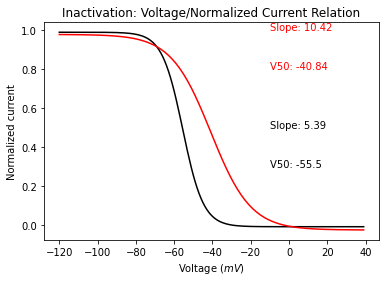

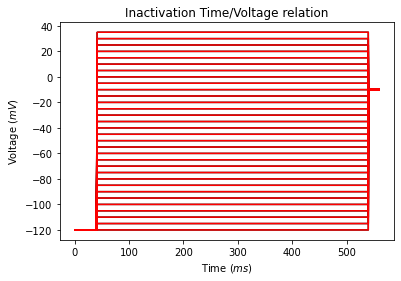

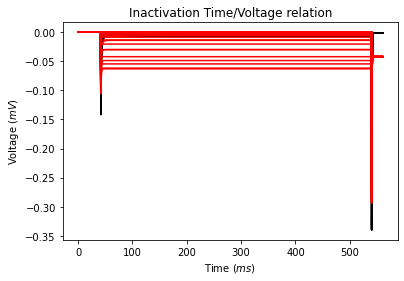

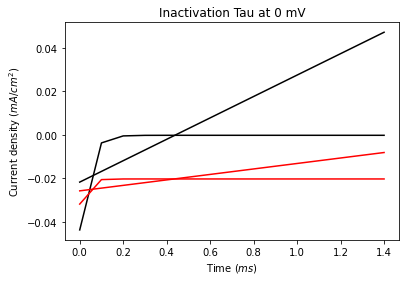

In [4]:
eh16.make_inact_plots(newparam)

In [4]:
# WT params

param_values_wt = [8.0,
 -35.0,
 7.2,
 0.4,
 0.124,
 -45.0,
 -45.0,
 0.5,
 1.5,
 0.02,
 0.01,
 2.0,
 0.01,
 0.03,
 10.0,
 -55.0,
 -55.0,
 7.0,
 -60.0,
 0.0003,
 12.0,
 0.2,
 10.0,
 -58.0,
 2.0,
 55.0]

In [5]:
# 109 generations 1st try (+-30)


param_values11 = [-4.838063776211033, -6.500868221860941, 3.0809057790559757, -15.655102845474135, 8.799507381501677, -52.90996308809248, -74.79684105148111, 24.544195740363534, 14.461408869921101, 0.34813950167300955, 7.0066834785240815, 14.241550185510228, -10.74321301843419, -8.834740381393, 17.80093872902765, -67.05194585707177, -74.15170402661235, -8.856267140905459, -36.656273955245545, -22.559752179891838, 28.463517044761037, 0.6573817354712941, 35.302494608144734, -42.806577468440324, -25.10600123145249, 75.00124166443648]

In [6]:
# midway 1st prot. (+-30)


param_values12 = [-7.054596008226149, -8.621887500606201, 4.376040239720496, -2.2789618103568703, 7.13352120304659, -41.97009852254292, -71.11578061450727, 12.687182707411836, 20.99726017037329, 3.1759254595038424, 13.756758694583612, 14.360471762055665, -9.769130127507514, -12.330354211033098, 7.15163280156775, -36.1035284473473, -74.15170402661235, -7.430980689951879, -36.74698786279601, -9.051512551824993, 36.81534730137548, -0.4227320206587226, 32.93362843322261, -42.806577468440324, -27.962406200892676, 81.84892126036067]

In [7]:
# stuck 2nd try (combining both)

param_values21 = [2.168833473297909, -13.385341809345402, 1.131517149614372, 1.404549814351375, 0.8879843843440589, -72.77927884539854, -53.94006368967891, 4.218460785733295, 4.234185025535455, 0.15231661204038194, 0.006239098017250839, 11.415110284182932, 0.08820572865329598, 0.06757675944280798, 24.880052903755583, -47.33792278315187, -31.374128820480642, 29.995649011038907, -55.37135129546485, 0.00018779059034513076, 4.905637220788834, 1.96444500704732, 38.38136275942096, -64.67779044972197, 2.4718141134791094, 63.25310604397935]

In [8]:
# midway 3rd try (scaling param)


param_values31 =  [7.264978743741452, -29.59251937617766, 2.3675843068311746, 1.1508729052472484, 0.548268249692106, -21.90899274675581, -35.10215809646758, 3.3003679469703187, 0.6555958418197378, 0.1314244484203889, 0.0836022970752898, 8.697042615423532, 0.08505860498576735, 0.11316236182494616, 5.5940684867994275, -31.332387097215655, -25.57615361560937, 23.16088745876642, -75.64076260699068, 0.00015896392941432656, 16.505761871214034, 1.775611237928496, 13.662564679440626, -38.85743914791794, 10.049036959572579, 81.697903355955]
param_values32 = [22.804726436549995, -44.61970844753197, 1.8274892840546961, 1.2769928030618307, 0.8193548486258277, -20.67873568428271, -65.86767366488536, 2.476086410530929, 0.401760458314679, 0.1629003218460831, 0.08099920073931717, 8.697042615423532, 0.08693829576349976, 0.2853298869008113, 7.705009285304498, -30.427461443875565, -25.57615361560937, 24.40576430188931, -70.17431705952976, 0.0027230284621963014, 16.732463228492243, 1.0795979275314065, 11.583729538808727, -38.85743914791794, 15.431628927543144, 83.471331910314]
param_values33 = [2.8313974822095505, -13.48421195768508, 1.571859415220314, 3.2579051337379035, 1.0845096825846916, -69.98723105637697, -47.42061389471313, 2.2811299495441144, 0.5547810773994453, 0.19021722876291092, 0.0018932210869944, 2.985571744180132, 0.09141868114720857, 0.1698643261085803, 33.612412108440324, -37.40191592951499, -43.87242250249343, 28.54409393874935, -86.5578527876153, 0.00011019501745118524, 2.9841637364179947, 1.8526576798062455, 39.55020496810514, -69.00977591524159, 2.9516994519152053, 82.30847202053934]
par34 = [0.8426794919425931, -13.45744025056562, 0.8067282348464224, 2.1020907943869234, 1.1952960804907642, -71.3383121657063, -52.41755113516413, 2.9535470758497118, 5.8710289736675385, 0.1630241836984601, 0.0012627820347382926, 2.7037070062571136, 0.06958875602925048, 0.21719720694264844, 39.719536283823544, -60.786807349301526, -50.212948760336445, 33.10456853694635, -44.36615250979315, 0.00019049331778212778, 5.192556190848775, 1.721648451460631, 39.952406028270154, -64.62718721878137, 2.734912725725311, 84.93272882822504]
par35 = [2.168833473297909, -13.385341809345402, 1.131517149614372, 1.404549814351375, 0.8496773998003524, -71.17543896341554, -57.97702758764516, 4.297208511164628, 4.234185025535455, 0.1421559091306656, 0.006239098017250839, 9.599362098934295, 0.09919320497927192, 0.05032993374208987, 30.237084193367888, -26.85217684326001, -30.70809302251292, 31.649354444523798, -56.56415937442149, 0.0003235606412921714, 5.00423801820624, 1.9699130376155465, 38.11210480085012, -75.1043012805384, 3.5823798951588754, 69.01023937445436]

In [9]:
# 4h narrow try (yes ratio, bad)

par41 = [9.447151969412971, -33.883285826756854, 2.202874391037364, 1.1065159529105053, 0.4908595553340912, -41.13670354776862, -49.185973034782144, 2.1346243404698546, 1.2198307857419937, 0.08383502641482826, 0.03938203808236943, 4.445367156444596, 0.04145275654944436, 0.05637149705620237, 8.479979794958606, -55.69435019145731, -50.10061629860154, 4.312417030478473, -63.62631494242396, 0.0012427800566212842, 8.623860367620475, 0.9254508007810008, 10.792667984789267, -58.87965128848724, 2.1184159840408925, 56.63787320149734]

In [10]:
# 5h narrow sqrd diff (no ratio)

par51 = [11.196851798815652, -38.106019119033434, 10.172848125240957, 3.5341896804599244, 2.83883219094725, -48.89850043750979, -45.997186501931004, -3.452025067405023, 3.686299259247355, 4.960616456920436, 0.23729118987897824, 3.5196462335370517, 1.6805714375247467, -3.5428291100878324, 8.71461627245328, -56.51103146878005, -52.493770913503596, 6.1138612803964865, -61.31953239695845, 0.4902801256409832, 9.059414550337117, -4.147079161940114, 7.380017283555881, -62.79152454130087, 3.694617971298986, 54.567610456384635]
par52 = [12.236583225507502, -30.013567158422724, 2.7565306866394352, 2.5446977584160972, 3.871508104357064, -47.988858776399496, -42.13463133579273, -0.4775303756026986, 2.6016432282992055, -0.17870986681945833, -3.2798795941169008, 5.395816322018223, 4.710346744997231, -3.596006284437383, 12.846368925796448, -50.643424495396985, -56.48714620896996, 10.045601114307438, -56.733541447791566, -2.4993866604162744, 14.678915295085947, 2.0984029552872787, 13.918871034885488, -57.217087317861306, 3.8972560683712616, 58.48447594073433]
par53 = [12.860994783553165, -30.139395670642326, 2.4938952448741665, 2.91931966830551, 4.804885595332683, -48.38876227501079, -48.86728887523238, -2.301819729770472, 2.1905801224458523, -0.5582380879412642, 0.4373749244783046, 2.9541254619734882, 4.44541980455944, -3.8897430068929593, 7.891933124566899, -56.36034204927389, -50.99843849007169, 4.562264739387971, -60.118707526685256, -3.4785193153773752, 8.571159915042095, -1.0797109787454073, 13.668398986044128, -58.89822003862351, 0.31799741945726656, 56.54568008528056]
par54 = [12.890860572522325, -30.090735880360498, 2.2038064815289093, 2.5144158840649147, 4.584064054938778, -46.66835013659455, -40.36015531766698, -0.44005365753910763, 2.2729376090753437, -1.3834941463002555, -1.7980256481070955, 2.9544503166146123, 3.8772005073129185, -3.81103744622144, 9.203838086038324, -50.62865168916052, -55.19871521739343, 8.960176278117427, -58.81105466326602, -0.5422954392624026, 11.095101219435033, -0.7534702947510707, 13.703774288737995, -61.34906691916254, 1.7307643053938637, 54.62384931644459]
par55 = [10.393240827163703, -31.115397128306967, 12.122488598013584, -3.2589563379221866, 4.057524549469305, -41.50591986309596, -42.48986184246456, -0.22525996586257924, 1.8412569331262976, 0.12694403270353227, 1.4126195610828514, 2.4750552217742183, 1.0356976871777268, 1.706570272853316, 12.935677256200012, -50.763964552446176, -52.44235053140831, 6.81505975299754, -63.996881386141325, -3.20860356583733, 12.224161000011035, -0.31121178804803395, 12.528509993381437, -61.8396417702247, 1.6503321158736894, 53.028114482283904]



# 6th narrow, ratio, after debugging
par61 = [10.440684847812204, -35.171323545152624, 11.980860436438517, 2.933703685347896, -0.959132834005604, -47.35356606033038, -40.20245072689268, 5.3592213398748925, -1.656728509467595, -4.196397601333703, 1.8148218950110873, 6.582393746117875, 0.9405134807388272, -3.123996559506292, 9.092324850123482, -53.50822677239906, -59.23238999980036, 2.2286751817616954, -64.26476295581666, -2.3424078340457517, 8.067042967769904, -2.072305023417668, 10.051971571133855, -53.770119913082155, -2.215032394591691, 50.42300107640875]
par62 = [12.851275238906826, -30.569734506619213, 3.9857906641961907, -1.0400278974044506, 5.119803526732841, -41.055311310817835, -41.928933672107526, 4.127696150516607, 4.317661874264665, 1.2904160668143803, 1.6684346722460228, 1.0064832091021079, -4.292629987714757, 4.703787315029191, 7.0455300807355545, -57.25280060370326, -53.922830981082, 11.64931724953275, -62.8983211470858, -2.909239013052808, 10.659311164768457, -1.5870574364896897, 9.029553029264648, -59.216841038016256, -0.7605008505238386, 59.41821927506734]
# 198th generation
par63 = [11.285549577770897, -30.479942173973633, 5.93331125370576, -1.012607888912663, 3.6274601632254218, -40.68621119533254, -42.077809531730935, 1.7788790179629017, 4.9073145182215665, 1.830667675134786, -1.055963015344623, 0.006418487681439711, -4.976261860699018, 4.733030715754692, 6.414360750756898, -57.11958868716005, -53.66727953209398, 9.94909007291538, -64.51466375193942, -0.9411396159637673, 13.941304258461093, -3.7669978281778063, 6.883265586100675, -61.39755399242811, 1.4993620811274193, 55.494283463470566]

In [12]:
# 7th wide sqrd diff

#93th gen
par71 = [13.00996573525628, -25.40687611510158, 0.018739734097008076, 5.588394503737478, 4.525791581794909, -36.05173658867092, -51.87548910167211, 0.1529908799628692, 6.495229315347701, -8.306068793042668, 9.515426641350665, 10.396049579587729, 7.313305956689506, -0.5905659212779444, 6.556678314245656, -63.811559695557875, -45.003358836718434, -0.3716379126754792, -53.57744218616252, 1.4728528608044031, 21.826634169044155, 9.740074394651213, 9.549317572682138, -54.02011764085921, -1.060715296742206, 59.10916508065492]

par7g1 = [4.06831643744123, -30.022122849675604, 12.187743977838576, 3.909106862394916, -0.4184636252475533, -42.70359258579219, -40.895050367285485, 0.9198819675512429, -2.248721203878987, 4.782691707509862, 0.3873349673675399, 4.696265821805066, 1.23511951702167, -4.322258534355723, 9.619670754917575, -59.880248260006766, -57.3409997131773, 11.615358673177173, -58.08539256292171, 0.6572178701520262, 8.120436198851397, 2.052405095267522, 11.054452852886863, -56.625372819920194, 3.883345885040325, 59.27896014506979]
par7g2 = [10.466490368444386, -35.171323545152624, 11.623135578402167, 2.933703685347896, -0.9522601725821891, -45.22472350643377, -40.20245072689268, 5.047045542341978, -1.656728509467595, -4.196397601333703, 1.8824219665774766, 6.591408946820959, 1.270857729403378, -3.123996559506292, 9.1110881372687, -52.662746591813885, -59.49894966097712, 2.4800195459787897, -55.646373575329875, -2.3424078340457517, 8.069375962342674, -2.1899866093594724, 11.32141087734821, -53.770450848669505, -2.215032394591691, 50.42300107640875]
par7g5 = [9.464278466821291, -35.168690140064825, 11.81242585194029, 3.3687888766716823, -1.0393873208292859, -44.73780307191911, -40.3137505523389, 5.346596175585045, -2.9450949652790763, -4.196397601333703, 1.8824219665774766, 6.49710746609126, -3.1892812292969035, 1.153860789138479, 6.909788347110769, -52.77692890207277, -59.99305530704136, 3.017751738187516, -55.227340657916024, -2.3424078340457517, 8.071367137643957, -2.176178784144335, 12.679950314708538, -53.77320749975218, -2.2278350738209745, 51.32880513190964]
par7g7 = [12.851275238906826, -30.569734506619213, 3.9857906641961907, -1.0400278974044506, 5.119803526732841, -41.055311310817835, -41.928933672107526, 4.127696150516607, 4.317661874264665, 1.2904160668143803, 1.6684346722460228, 1.0064832091021079, -4.292629987714757, 4.703787315029191, 7.0455300807355545, -57.25280060370326, -53.922830981082, 11.64931724953275, -62.8983211470858, -2.909239013052808, 10.659311164768457, -1.5870574364896897, 9.029553029264648, -59.216841038016256, -0.7605008505238386, 59.41821927506734]
par7g12 = [12.851275238906826, -30.56395293456726, 3.9857906641961907, -1.0400278974044506, 5.083058469893922, -40.48200927518083, -41.38596065912027, 3.618886650968328, 3.553819943725358, 0.23553964988782883, 2.0702689751873296, 1.0064832091021079, -4.337161190979538, 4.733273042876608, 7.0455300807355545, -57.25280060370326, -53.68521174524943, 11.214371872369101, -62.8983211470858, -3.019995932913373, 10.472413881880657, 1.015580122648705, 8.766866272151303, -59.165537812776414, -0.1260619401520483, 59.41821927506734]
par7g17 = [12.933472983132619, -30.569081163805752, 3.9857906641961907, -1.0400278974044506, 5.09384721137855, -40.48200927518083, -42.44327893405759, 3.618886650968328, 4.3348507302527555, 0.06422207462538282, 1.6673494045704993, 0.006418487681439711, -4.892680232506268, 4.733030715754692, 7.0455300807355545, -57.25280060370326, -54.85785941463834, 8.540437252111843, -62.8983211470858, -2.903521348424969, 10.658703231741352, -2.743121211724917, 8.766866272151303, -61.39755399242811, 1.3425605560938587, 58.933858192265646]
par7g24 = [12.999378269100376, -30.569081163805752, 3.9857906641961907, -1.0400278974044506, 5.09384721137855, -40.48200927518083, -42.12623153845005, 3.0991049995049744, 4.665271225866243, 0.06422207462538282, -0.6413315735299678, 0.006418487681439711, -4.892680232506268, 4.733030715754692, 6.812718391686394, -56.06647751664648, -54.56397883386449, 8.540437252111843, -64.9709637189791, -2.903521348424969, 10.507408542207198, -3.296489234603188, 8.766866272151303, -61.39755399242811, 1.3425605560938587, 57.71921494775483]
par7g26 = [12.933472983132619, -30.569081163805752, 4.5605095426173206, -1.0400278974044506, 4.285648611714343, -40.48200927518083, -42.85387694789564, 3.618886650968328, 4.3348507302527555, 0.06422207462538282, 1.6673494045704993, 0.006418487681439711, -4.892680232506268, 4.733030715754692, 7.0455300807355545, -57.25280060370326, -54.85785941463834, 8.540437252111843, -62.8983211470858, -2.6529290525922122, 11.367500901753978, -2.9420304498202343, 8.766866272151303, -61.39755399242811, 1.3871357325049412, 59.60433416286954]
par7g30 = [12.938113048433749, -30.569081163805752, 3.416073148629784, -1.0400278974044506, 3.77566985551024, -40.67495193747668, -42.10335778178065, 2.1372735462400434, 4.4526004652816, 1.298775404275376, -0.5654547872199964, 0.006418487681439711, -4.955751914541212, 4.733030715754692, 7.0455300807355545, -57.25280060370326, -54.58132822670663, 8.540437252111843, -64.51466375193942, -2.903521348424969, 10.658703231741352, -4.128489348785176, 8.766866272151303, -61.39755399242811, 1.3425605560938587, 56.62309359891254]
par7g40 = [12.983203321790079, -31.09127418706607, 3.416073148629784, -1.0400278974044506, 4.3156830706159575, -41.78489821804994, -42.15815644104166, 0.8336672820106734, 4.941010050207458, 1.298775404275376, -0.5654547872199964, 0.006418487681439711, -4.955751914541212, 4.733030715754692, 7.268776182021619, -57.25280060370326, -54.58132822670663, 8.540437252111843, -63.404159835372916, -1.8908345753198275, 10.658703231741352, -4.135185120253445, 8.766866272151303, -59.538631716753024, 1.3425605560938587, 57.5923609392671]

In [13]:
# narrow, ratio * 100

par81 = [12.851275238906826, -30.569734506619213, 3.9857906641961907, -1.0400278974044506, 5.119803526732841, -41.055311310817835, -41.928933672107526, 4.127696150516607, 4.317661874264665, 1.2904160668143803, 1.6684346722460228, 1.0064832091021079, -4.292629987714757, 4.703787315029191, 7.0455300807355545, -57.25280060370326, -53.922830981082, 11.64931724953275, -62.8983211470858, -2.909239013052808, 10.659311164768457, -1.5870574364896897, 9.029553029264648, -59.216841038016256, -0.7605008505238386, 59.41821927506734]
par823 = [12.851275238906826, -30.56395293456726, 3.9857906641961907, -1.0400278974044506, 5.12003103087953, -40.117023284144196, -41.38596065912027, 4.352217296685996, 3.638309515048711, 1.3618799317567922, 2.604132950987549, 0.8622875524842308, -2.7285112508716276, 4.738196785765688, 7.127402242674801, -57.25280060370326, -53.68521174524943, 11.218182129927158, -62.8983211470858, -3.4406404413054466, 10.472413881880657, 0.7653783520045633, 8.770002611623875, -58.64294383373615, -0.1260619401520483, 59.41821927506734]
par860 = [11.285549577770897, -30.479942173973633, 5.93331125370576, -1.012607888912663, 3.6274601632254218, -40.68621119533254, -42.077809531730935, 1.7788790179629017, 4.9073145182215665, 1.830667675134786, -1.055963015344623, 0.006418487681439711, -4.976261860699018, 4.733030715754692, 6.414360750756898, -57.11958868716005, -53.66727953209398, 9.94909007291538, -64.51466375193942, -0.9411396159637673, 13.941304258461093, -3.7669978281778063, 6.883265586100675, -61.39755399242811, 1.4993620811274193, 55.494283463470566]

In [18]:
# scaled ratio

par91 = [12.134730441814906, -38.580734604849034, 10.991214438292662, -2.4373164322919036, 3.539897548272802, -41.51770317797501, -46.64535288772798, 4.385923720325765, -1.9023220721181802, 3.511095140212456, -1.1726545124404, 1.39717601281703, -3.8114021938514036, 1.0400526470797926, 7.697558201498719, -53.33120698578991, -52.00612055965721, 8.036840226733041, -64.91815190484529, 4.523652385289846, 16.196811677159857, 1.6293532172275613, 8.795063476785167, -57.38086234463068, 5.828120686199002, 54.595288040516245]

In [19]:
new_params = par91

Garbage below...

In [17]:
gv_slope, v_half, top, bottom = cf.calc_act_obj("na16", is_HMM=False)

/Users/jinanjiang/Documents/Berkeley/temp_delete/SimulatingVariants/generalized_genSim_shorten_time.py:163: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/jinanjiang/Documents/Berkeley/temp_delete/SimulatingVariants/generalized_genSim_shorten_time.py:171: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))
/Users/jinanjiang/Documents/Berkeley/temp_delete/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


In [3]:
print(v_half)
print(gv_slope)

-24.76279856030555
6.183933364396658


In [4]:
ssi_slope, v_half, top, bottom, tau0 = cf.calc_inact_obj("na16", is_HMM=False)

In [5]:
print(v_half)
print(ssi_slope)

-55.49616240483763
5.390056117452175


In [6]:
currh = ggsd.Activation(channel_name = 'na16').h

In [7]:
currh.sh_na16
#currh.gbar_na16
currh.tha_na16
currh.qa_na16
currh.Ra_na16
currh.Rb_na16
currh.thi1_na16
currh.thi2_na16
currh.qd_na16
currh.qg_na16
currh.mmin_na16
currh.hmin_na16
currh.q10_na16
currh.Rg_na16
currh.Rd_na16
currh.qq_na16
currh.tq_na16
currh.thinf_na16
currh.qinf_na16
currh.vhalfs_na16
currh.a0s_na16
currh.zetas_na16
currh.gms_na16
currh.smax_na16
currh.vvh_na16
currh.vvs_na16
#currh.ar2_na16
#currh.ena_na16
currh.Ena_na16

55.0

In [ ]:
param_list = eh16.get_param_list_in_str()

In [9]:
eval(param_list)

[8.0,
 -35.0,
 7.2,
 0.4,
 0.124,
 -45.0,
 -45.0,
 0.5,
 1.5,
 0.02,
 0.01,
 2.0,
 0.01,
 0.03,
 10.0,
 -55.0,
 -55.0,
 7.0,
 -60.0,
 0.0003,
 12.0,
 0.2,
 10.0,
 -58.0,
 2.0,
 55.0]

In [10]:
lst = []
cur = ''
flag = 0
for c in param_list:
    if c == ',':
        lst.append(cur)
        cur = ''
        flag = 1
    elif flag:
        flag = 0
        continue
    else:
        cur += c
print(lst) 

['[currh.sh_na16', 'currh.tha_na16', 'currh.qa_na16', 'currh.Ra_na16', 'currh.Rb_na16', 'currh.thi1_na16', 'currh.thi2_na16', 'currh.qd_na16', 'currh.qg_na16', 'currh.mmin_na16', 'currh.hmin_na16', 'currh.q10_na16', 'currh.Rg_na16', 'currh.Rd_na16', 'currh.qq_na16', 'currh.tq_na16', 'currh.thinf_na16', 'currh.qinf_na16', 'currh.vhalfs_na16', 'currh.a0s_na16', 'currh.zetas_na16', 'currh.gms_na16', 'currh.smax_na16', 'currh.vvh_na16', 'currh.vvs_na16']


In [11]:
param_list_str = ['currh.sh_na16', 'currh.tha_na16', 'currh.qa_na16', 'currh.Ra_na16', 'currh.Rb_na16', 'currh.thi1_na16', 'currh.thi2_na16', 'currh.qd_na16', 'currh.qg_na16', 'currh.mmin_na16', 'currh.hmin_na16', 'currh.q10_na16', 'currh.Rg_na16', 'currh.Rd_na16', 'currh.qq_na16', 'currh.tq_na16', 'currh.thinf_na16', 'currh.qinf_na16', 'currh.vhalfs_na16', 'currh.a0s_na16', 'currh.zetas_na16', 'currh.gms_na16', 'currh.smax_na16', 'currh.vvh_na16', 'currh.vvs_na16', 'currh.Ena_na16']

In [12]:
for i in param_list_str:
    print(eval(i))

8.0
-35.0
7.2
0.4
0.124
-45.0
-45.0
0.5
1.5
0.02
0.01
2.0
0.01
0.03
10.0
-55.0
-55.0
7.0
-60.0
0.0003
12.0
0.2
10.0
-58.0
2.0
55.0


init called


evaluate_with_lists is called
Couldn't generate activation data


/global/u1/j/jinan/SimulatingVariants/generalized_genSim_shorten_time.py:463: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
evaluate_with_lists is called


/global/u1/j/jinan/SimulatingVariants/generalized_genSim_shorten_time.py:163: RuntimeWarning: overflow encountered in exp
  return Gmax * (vm - self.vrev) / (1 + np.exp((v_half - vm) / s))
/global/u1/j/jinan/SimulatingVariants/generalized_genSim_shorten_time.py:171: RuntimeWarning: overflow encountered in exp
  norm_g.append(1 / (1 + np.exp(-(volt - self.v_half) / self.s)))


Couldn't fit curve to activation.
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called


/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/j/jinan/.conda/envs/.env/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
ev

/global/u1/j/jinan/SimulatingVariants/generalized_genSim_shorten_time.py:1562: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called


/global/u1/j/jinan/SimulatingVariants/curve_fitting.py:17: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))


Couldn't fit curve to activation.
Couldn't fit curve to inactivation.
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't gener

/global/u1/j/jinan/SimulatingVariants/generalized_genSim_shorten_time.py:1547: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/global/u1/j/jinan/SimulatingVariants/generalized_genSim_shorten_time.py:1547: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
evaluate_with_lists is called
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't generate activation data
Couldn't fit curve to inactivation.
evaluate_with_lists is called
Couldn't

In [ ]:
for i in hof[0]:
    print(i)

In [ ]:
best_indvs